In [1]:
from __future__ import print_function
import argparse
from math import log10

import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
from collections import defaultdict
import time

In [2]:
from super_resolution.model import Net, BayesianNet
from super_resolution.data import get_training_set, get_test_set

c:\Users\fedor\anaconda3\envs\espcn\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [3]:
#upscale_factor = 3

class store:
    def __init__(self, up, b, t, n, l, th, se, ds):
        self.upscale_factor = up
        self.batchSize = b
        self.testBatchSize = t
        self.nEpochs = n
        self.lr = l
        self.threads = th
        self.seed = se
        self.dataset = ds
        
upscale_factor = 3
batchSize = 4
testBatchSize = 100

#nEpochs = 2
nEpochs = 10
lr = .001
dataset = "coco"
threads = 3
seed = 123
        
opt = store(upscale_factor, batchSize, testBatchSize, nEpochs, lr, threads, seed, dataset)


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
# device = torch.device("cpu")
#torch.manual_seed(seed)

In [5]:
print('===> Loading datasets')
train_set = get_training_set(opt.upscale_factor, dataset=opt.dataset)
test_set = get_test_set(opt.upscale_factor, dataset=opt.dataset)
training_data_loader = DataLoader(dataset=train_set, num_workers=opt.threads, batch_size=opt.batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.testBatchSize, shuffle=False)
print(train_set)

===> Loading datasets


In [6]:
print('===> Building model')
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}

===> Building model


In [7]:
def train(model, optimizer, criterion, epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        torch.cuda.empty_cache()
        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        kl = 0
        if model.__class__.__name__ == 'BayesianNet':
            output, kl = model(input)
        else:
            output = model(input)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    return epoch, epoch_loss / len(training_data_loader)


def test(model, criterion):
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].to(device), batch[1].to(device)

            if model.__class__.__name__ == 'BayesianNet':
                prediction, kl = model(input)
            else:
                prediction = model(input)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
    return avg_psnr / len(testing_data_loader)


def checkpoint(model, epoch, upscale_factor):
    ckpt_dir = f'./super_resolution/models/{model.__class__.__name__}/{opt.dataset}'
    model_out_path = f"./super_resolution/models/{model.__class__.__name__}/{opt.dataset}/epoch_{epoch}_upscale_factor_{upscale_factor}_device_{str(device).split(':')[0]}.pth"

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)
    
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [8]:
model = BayesianNet(1, upscale_factor, priors, layer_type='lrt')

In [9]:
type(model.conv2)

layers.BBB_LRT.BBBConv.BBBConv2d

In [10]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


for upscale_factor in [opt.upscale_factor]:
    models = {"Bayesian CNN": BayesianNet(1, upscale_factor, priors, layer_type='lrt').to(device),
        "Classical CNN": Net(upscale_factor=upscale_factor).to(device)
    }
    epochs = defaultdict(list)
    epoch_losses = defaultdict(list)
    avg_psnrs = defaultdict(list)
    times = defaultdict(list)
    
    file_name_epoch_loss = f"upscale_{upscale_factor}__total_epocs_{opt.nEpochs}_epoch_loss"
    file_name_ave_psnrs = f"upscale_{upscale_factor}__total_epocs_{opt.nEpochs}_avg_psnrs"
    file_name_times = f"upscale_{upscale_factor}__total_epocs_{opt.nEpochs}_times"
    
    for model_name in models.keys():
        model = models[model_name]

        criterion = nn.MSELoss()

        optimizer = optim.Adam(model.parameters(), lr=opt.lr)
        
        prev_time = time.time()
        for epoch in range(1, opt.nEpochs + 1):
            # TODO: for stats see train.py
            epoch, epoch_loss = train(model, optimizer, criterion, epoch)
            avg_psnr = test(model, criterion)
            checkpoint(model, epoch, upscale_factor)
            
            epochs[model_name].append(epoch)
            epoch_losses[model_name].append(epoch_loss)
            avg_psnrs[model_name].append(avg_psnr)
            times[model_name].append(time.time() - prev_time)
            prev_time = time.time()
            
    result_dir = f'./stats/{opt.dataset}'
    if not os.path.exists(result_dir):
        os.makedirs(result_dir, exist_ok=True)
        
    epoch_losses_df = pd.DataFrame.from_dict(epoch_losses)
    epoch_losses_df["epoch"] = epoch_losses_df.index + 1
    avg_psnrs_df = pd.DataFrame.from_dict(avg_psnrs)
    avg_psnrs_df["epoch"] = epoch_losses_df.index + 1
    times_df = pd.DataFrame.from_dict(times)
    times["epoch"] = epoch_losses_df.index + 1
    
    epoch_losses_df.to_csv(f"./stats/{opt.dataset}/{file_name_epoch_loss}.csv")
    avg_psnrs_df.to_csv(f"./stats/{opt.dataset}/{file_name_ave_psnrs}.csv")
    times_df.to_csv(f"./stats/{opt.dataset}/{file_name_times}.csv")

===> Epoch[1](1/1250): Loss: 2.4425
===> Epoch[1](2/1250): Loss: 2.3911
===> Epoch[1](3/1250): Loss: 1.6134
===> Epoch[1](4/1250): Loss: 1.3728
===> Epoch[1](5/1250): Loss: 1.0170
===> Epoch[1](6/1250): Loss: 0.7257
===> Epoch[1](7/1250): Loss: 0.6664
===> Epoch[1](8/1250): Loss: 0.6796
===> Epoch[1](9/1250): Loss: 0.4440
===> Epoch[1](10/1250): Loss: 0.5166
===> Epoch[1](11/1250): Loss: 0.5364
===> Epoch[1](12/1250): Loss: 0.5671
===> Epoch[1](13/1250): Loss: 0.4245
===> Epoch[1](14/1250): Loss: 0.3325
===> Epoch[1](15/1250): Loss: 0.3205
===> Epoch[1](16/1250): Loss: 0.4005
===> Epoch[1](17/1250): Loss: 0.3370
===> Epoch[1](18/1250): Loss: 0.3583
===> Epoch[1](19/1250): Loss: 0.2226
===> Epoch[1](20/1250): Loss: 0.2595
===> Epoch[1](21/1250): Loss: 0.2647
===> Epoch[1](22/1250): Loss: 0.2748
===> Epoch[1](23/1250): Loss: 0.1758
===> Epoch[1](24/1250): Loss: 0.2610
===> Epoch[1](25/1250): Loss: 0.2141
===> Epoch[1](26/1250): Loss: 0.2076
===> Epoch[1](27/1250): Loss: 0.1880
===> Epoch

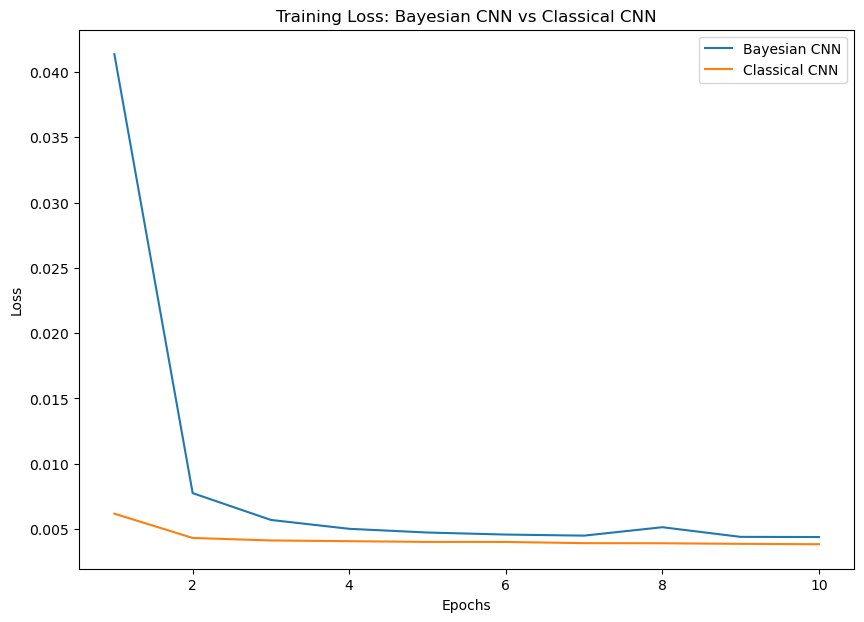

In [11]:
# loss plots
plt.figure(figsize=(10, 7))
plt.title(f"Training Loss: Bayesian CNN vs Classical CNN")

for model_name in epochs:
    plt.plot(epochs[model_name], epoch_losses[model_name], label=model_name)
# plt.plot(val_loss, color='red', label='validataion loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig(f'./graphs/loss_model_{model.__class__.__name__}_epochs_{opt.nEpochs}_upscale_factor_{upscale_factor}.png')

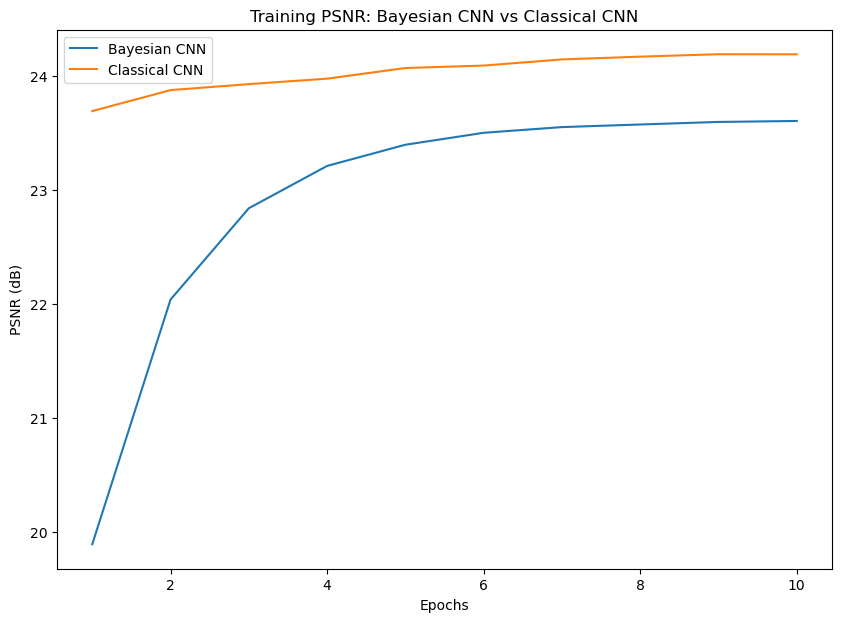

In [12]:
# loss plots
plt.figure(figsize=(10, 7))
plt.title(f"Training PSNR: Bayesian CNN vs Classical CNN")

for model_name in epochs:
    plt.plot(epochs[model_name], avg_psnrs[model_name], label=model_name)

# plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()    

